# -1) configuration 
## -1.1) set a user flag in a notebook cell:

In [1]:
USER_FLAG = "--user"

## -1.2) install python librairies for aiplatform

In [2]:
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.7.0 --upgrade
!pip3 install {USER_FLAG} kfp==1.8.9 google-cloud-pipeline-components==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 16.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## -1.3) rebooting the kernel after installation

In [2]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## -1.4) testing reboot confirmation

In [1]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
!python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.9
google_cloud_pipeline_components version: 0.2.0


# 0) importing librairies

In [2]:
import kfp

from typing     import NamedTuple

from kfp.v2     import dsl
from kfp.v2     import compiler

from kfp.v2.dsl import Input
from kfp.v2.dsl import Model
from kfp.v2.dsl import Output
from kfp.v2.dsl import Metrics
from kfp.v2.dsl import Artifact
from kfp.v2.dsl import pipeline
from kfp.v2.dsl import component
from kfp.v2.dsl import ClassificationMetrics


from google.cloud                     import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip


# 1) configuration

## 1.1) fetching current project id

In [3]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output =!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID   = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  helical-sanctum-353821


## 1.2) setting bucket name (to be configured)

In [4]:
BUCKET_NAME="gs://" + PROJECT_ID + "-bucket"

## 1.3) define constants

In [5]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"

PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jupyter/.local/bin


'gs://helical-sanctum-353821-bucket/pipeline_root/'

# 2) creating pipeline components

## 2.1) Component just returning a string

In [6]:
parameters                          = {}
parameters["base_image"]            = "python:3.9"
parameters["output_component_file"] = "component-simple-string-return.yaml" 

@component(**parameters)
def product_name(text: str) -> str:
    return text

## 2.2) Component change a string into an emoji

In [7]:
parameters                          = {}
parameters["packages_to_install"]   = ["emoji"]
parameters["output_component_file"] = "component-transform-string-to-emoji.yaml" 

@component(**parameters)
def emoji(text: str,) -> NamedTuple("Outputs", [("emoji_text", str), ("emoji", str),],):
    import emoji
    emoji_text = text
    emoji_str  = emoji.emojize(':' + emoji_text + ':', use_aliases=True)
    print("output one: {}; output_two: {}".format(emoji_text, emoji_str))
    return (emoji_text, emoji_str)

## 2.3) Concatenating the output of the two components

In [8]:
parameters                          = {}
parameters["output_component_file"] = "component-build-a-sentence.yaml" 

@component(**parameters)
def build_sentence(product: str,emoji: str,emojitext: str) -> str:
    end_str = product + " is "
    if len(emoji) > 0:
        end_str += emoji
    else:
        end_str += emojitext
    return(end_str)

# 3) Using Vertex Pipelines

# 3.1) creating a Pipeline

In [9]:
parameters                  = {}
parameters["name"]          = "hello-world" 
parameters["description"]   = "An intro pipeline" 
parameters["pipeline_root"] = PIPELINE_ROOT # Bucket

@pipeline(**parameters)
# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex Pipelines", emoji_str: str = "sparkles"):
    task_product = product_name(text)
    task_emoji   = emoji(emoji_str)
    parameters = {}
    parameters["product"]   = task_product.output
    parameters["emoji"]     = task_emoji.outputs["emoji"]
    parameters["emojitext"] = task_emoji.outputs["emoji_text"]
    
    consumer_task = build_sentence(**parameters)

## 3.2) compiling the pipeline

In [10]:
pipeline_desc_in_json = "intro_pipeline_job.json"

In [11]:
compiler_instance           = compiler.Compiler()
parameters                  = {}
parameters["pipeline_func"] = intro_pipeline
parameters["package_path"]  = pipeline_desc_in_json

compiler_instance.compile(**parameters)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


# 4) Run the pipeline

## 4.1) Define a pipeline job

In [16]:
from datetime import datetime

TIMESTAMP                    = datetime.now().strftime("%Y%m%d%H%M%S")

parameters                   = {}
parameters["display_name"]   = "hello-world-pipeline"
parameters["template_path"]  = pipeline_desc_in_json
parameters["job_id"]         = f'{parameters["display_name"]}-{TIMESTAMP}'
parameters["enable_caching"] = True

In [17]:
job = aiplatform..PipelineJob(**parameters)

## 4.3) Submit the job

In [18]:
job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/285226200443/locations/us-central1/pipelineJobs/hello-world-pipeline-20220620141509
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/285226200443/locations/us-central1/pipelineJobs/hello-world-pipeline-20220620141509')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-pipeline-20220620141509?project=285226200443


# 5) Using components stored in github

## 5.0) Store the yaml file in github

In [21]:
github_repo = "https://raw.githubusercontent.com/romainjouin/vertex-ai-demo/main/"
url_1 = f"{github_repo}component-simple-string-return.yaml"
url_2 = f"{github_repo}component-transform-string-to-emoji.yaml"
url_3 = f"{github_repo}component-build-a-sentence.yaml"

## 5.1) Load them into the pipeline

In [22]:
parameters                  = {}
parameters["name"]          = "github-pipeline" 
parameters["description"]   = "An intro pipeline" 
parameters["pipeline_root"] = PIPELINE_ROOT # Bucket

@pipeline(**parameters)
# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex Pipelines", emoji_str: str = "sparkles"):
    
    product_name   = kfp.components.load_component_from_url(url_1)
    emoji          = kfp.components.load_component_from_url(url_2)
    build_sentence = kfp.components.load_component_from_url(url_3)
    task_product   = product_name(text)
    task_emoji     = emoji(emoji_str)
    
    parameters              = {}
    parameters["product"]   = task_product.output
    parameters["emoji"]     = task_emoji.outputs["emoji"]
    parameters["emojitext"] = task_emoji.outputs["emoji_text"]
    
    consumer_task = build_sentence(**parameters)

## 5.2) Compile the pipeline

In [23]:
pipeline_desc_in_json = "pipeline_from_github.json"

In [24]:
compiler_instance           = compiler.Compiler()
parameters                  = {}
parameters["pipeline_func"] = intro_pipeline
parameters["package_path"]  = pipeline_desc_in_json

compiler_instance.compile(**parameters)

## 5.3) Define a pipeline job

In [25]:
from datetime import datetime

TIMESTAMP                    = datetime.now().strftime("%Y%m%d%H%M%S")

parameters                   = {}
parameters["display_name"]   = "hello-world-pipeline"
parameters["template_path"]  = pipeline_desc_in_json
parameters["job_id"]         = f'{parameters["display_name"]}-{TIMESTAMP}'
parameters["enable_caching"] = True

In [26]:
job = aiplatform.PipelineJob(**parameters)

## 5.4) Submit the job

In [27]:
job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/334775291029/locations/us-central1/pipelineJobs/hello-world-pipeline-20220210123045
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/334775291029/locations/us-central1/pipelineJobs/hello-world-pipeline-20220210123045')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-pipeline-20220210123045?project=334775291029


# 6) Going further with a pipeline creating an auto-ml modelisation for Beans

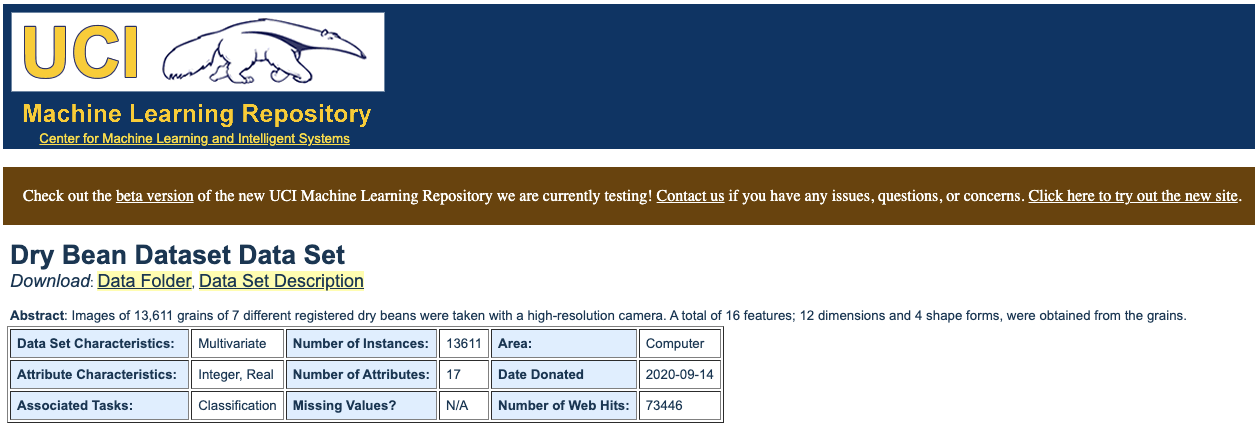

## 6.1) creating a component checking the model's performance

In [17]:
parameters                           = {}
parameters["base_image"]             = "gcr.io/deeplearning-platform-release/tf2-cpu.2-3:latest"
parameters["output_component_file"]  = "tabular_eval_component.yaml"
parameters["packages_to_install"]    = ["google-cloud-aiplatform"]

@component(**parameters)
def classification_model_eval_metrics(
    project              : str,
    location             : str,  # "us-central1",
    api_endpoint         : str,  # "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str  : str,
    model                : Input[Artifact],
    metrics              : Output[Metrics],
    metricsc             : Output[ClassificationMetrics],) -> NamedTuple(  "Outputs", 
                                                                         [("dep_decision", str)]):  # Return parameter.
    #------------------------------------------------------------------------
    # 0) imports
    #------------------------------------------------------------------------
    import json
    import logging
    from google.cloud import aiplatform as aip
    
    #------------------------------------------------------------------------
    # 1) internal function : Fetch model eval info
    #------------------------------------------------------------------------
    def get_eval_info(client, model_name):
        from google.protobuf.json_format      import MessageToDict
        metrics_list        = []
        metrics_string_list = []
        response            = client.list_model_evaluations(parent=model_name)
        
        for evaluation in response:
            print("model_evaluation")
            print(" name:", evaluation.name)
            print(" metrics_schema_uri:", evaluation.metrics_schema_uri)
            
            metrics = MessageToDict(evaluation._pb.metrics)
            for metric in metrics.keys():
                logging.info("metric: %s, value: %s", metric, metrics[metric])
            
            metrics_str = json.dumps(metrics)
            metrics_list.append(metrics)
            metrics_string_list.append(metrics_str)

        return (evaluation.name    ,
                metrics_list       ,
                metrics_string_list,)
    #------------------------------------------------------------------------
    # 2) internal function :  Use the given metrics threshold(s) to determine whether the model is
    # accurate enough to deploy.
    #------------------------------------------------------------------------
    def classification_thresholds_check(metrics_dict, thresholds_dict):
        for k, v in thresholds_dict.items():
            logging.info("k {}, v {}".format(k, v))
            if k in ["auRoc", "auPrc"]:  # higher is better
                if metrics_dict[k] < v:  # if under threshold, don't deploy
                    logging.info("{} < {}; returning False".format(metrics_dict[k], v))
                    return False
        logging.info("threshold checks passed.")
        return True
    #------------------------------------------------------------------------
    # 3) internal function :  Log metrics
    #------------------------------------------------------------------------
    def log_metrics(metrics_list, metricsc):
        test_confusion_matrix = metrics_list[0]["confusionMatrix"]
        logging.info("rows: %s", test_confusion_matrix["rows"])

        # log the ROC curve
        fpr = []
        tpr = []
        thresholds = []
        for item in metrics_list[0]["confidenceMetrics"]:
            fpr.append(item.get("falsePositiveRate", 0.0))
            tpr.append(item.get("recall", 0.0))
            thresholds.append(item.get("confidenceThreshold", 0.0))
        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")
        metricsc.log_roc_curve(fpr, tpr, thresholds)

        # log the confusion matrix
        annotations = []
        for item in test_confusion_matrix["annotationSpecs"]:
            annotations.append(item["displayName"])
        logging.info("confusion matrix annotations: %s", annotations)
        metricsc.log_confusion_matrix(annotations,test_confusion_matrix["rows"],)

        # log textual metrics info as well
        for metric in metrics_list[0].keys():
            if metric != "confidenceMetrics":
                val_string = json.dumps(metrics_list[0][metric])
                metrics.log_metric(metric, val_string)
    #------------------------------------------------------------------------
    # => Actual main code 
    #------------------------------------------------------------------------
    
    # 0) log configuration
    logging.getLogger().setLevel(logging.INFO)
    
    # 1) Artificial Intelligence Platform init
    aip.init(project=project)
    
    # 2) extract the model resource name from the input Model Artifact
    model_resource_path = model.metadata["resourceName"]
    logging.info("model path: %s", model_resource_path)
    
    # 3) settings api url 
    client_options = {"api_endpoint": api_endpoint}
    
    # 4) Initialize client that will be used to create and send requests.
    client                                    = aip.gapic.ModelServiceClient(client_options=client_options)
    
    # 5) Logs : 
    eval_name, metrics_list, metrics_str_list = get_eval_info(client, model_resource_path)
    logging.info("got evaluation name: %s", eval_name)
    logging.info("got metrics list: %s", metrics_list)
    log_metrics(metrics_list, metricsc)
    
    # 6) Test if the model is good enough
    thresholds_dict = json.loads(thresholds_dict_str)
    deploy          = classification_thresholds_check(metrics_list[0], thresholds_dict)
    
    # 7) log
    dep_decision            = "false"
    if deploy: dep_decision = "true"    
    logging.info("deployment decision is %s", dep_decision)
    
    # 8) Return test's value 
    return (dep_decision,)    

## 6.2) creating a unique name based on current time

In [18]:
import time
DISPLAY_NAME = 'automl-beans-{}'.format(str(int(time.time())))
print(DISPLAY_NAME)

automl-beans-1644354208


## 6.3) creating a pipeline 
1) creating a tabular dataset based on big Query  
2) Creating an auto-ml model
3) Callling the previous component to know if the model's performance is good enough
4) Using a conditional test from "dsl" library to decide or not to deploy
5) Creating an endpoint to serve the model

In [19]:
parameters                   = {}
parameters["name"]           = "automl-tab-beans-training-v2"
parameters["pipeline_root"]  = PIPELINE_ROOT

@pipeline(name="automl-tab-beans-training-v2",
                  pipeline_root=PIPELINE_ROOT)
def pipeline(
              bq_source: str           = "bq://aju-dev-demos.beans.beans1"       ,
              display_name: str        = DISPLAY_NAME                            ,
              project: str             = PROJECT_ID                              ,
              gcp_region: str          = "us-central1"                           ,
              api_endpoint: str        = "us-central1-aiplatform.googleapis.com" ,
              thresholds_dict_str: str = '{"auRoc": 0.95}'                       ,):
    #------------------------------------------------------------------------
    # 0) TabularDatasetCreateOp : 
    # Creates a tabular dataset in Vertex AI given a dataset source either in Cloud Storage or BigQuery. 
    # In this pipeline, we're passing the data via a BigQuery table URL
    #------------------------------------------------------------------------
    dataset_create_op = gcc_aip.TabularDatasetCreateOp( project      = project, 
                                                        display_name = display_name, 
                                                        bq_source    = bq_source)
    #------------------------------------------------------------------------
    # 1) AutoMLTabularTrainingJobRunOp : 
    # kicks off an AutoML training job for a tabular dataset. 
    # We pass a few configuration parameters to this component, including the model type (in this case, classification), 
    # some data on the columns, how long we'd like to run training for, and a pointer to the dataset. 
    # Notice that to pass in the dataset to this component, we're providing the output of the previous component via dataset_create_op.outputs["dataset"]
    #------------------------------------------------------------------------
    training_op = gcc_aip.AutoMLTabularTrainingJobRunOp(
                    budget_milli_node_hours      = 1000,
                    target_column                = "Class",
                    project                      = project,
                    display_name                 = display_name,
                    optimization_prediction_type = "classification",
                    dataset                      = dataset_create_op.outputs["dataset"],
                    column_transformations       = [{"numeric"    : {"column_name" : "Area"           }},
                                                    {"numeric"    : {"column_name" : "Perimeter"      }},
                                                    {"numeric"    : {"column_name" : "MajorAxisLength"}},
                                                    {"numeric"    : {"column_name" : "MinorAxisLength"}},
                                                    {"numeric"    : {"column_name" : "AspectRation"   }},
                                                    {"numeric"    : {"column_name" : "Eccentricity"   }},
                                                    {"numeric"    : {"column_name" : "ConvexArea"     }},
                                                    {"numeric"    : {"column_name" : "EquivDiameter"  }},
                                                    {"numeric"    : {"column_name" : "Extent"         }},
                                                    {"numeric"    : {"column_name" : "Solidity"       }},
                                                    {"numeric"    : {"column_name" : "roundness"      }},
                                                    {"numeric"    : {"column_name" : "Compactness"    }},
                                                    {"numeric"    : {"column_name" : "ShapeFactor1"   }},
                                                    {"numeric"    : {"column_name" : "ShapeFactor2"   }},
                                                    {"numeric"    : {"column_name" : "ShapeFactor3"   }},
                                                    {"numeric"    : {"column_name" : "ShapeFactor4"   }},
                                                    {"categorical": {"column_name" : "Class"          }},
                                                   ],
                     )
    #------------------------------------------------------------------------
    # 2) classification_model_eval_metrics : 
    #------------------------------------------------------------------------
    model_eval_task = classification_model_eval_metrics( project                      ,
                                                         gcp_region                   ,
                                                         api_endpoint                 ,
                                                         thresholds_dict_str          ,
                                                         training_op.outputs["model"] )

    #------------------------------------------------------------------------
    # 3) if model performance are good enough : 
    #  If accuracy doesn't meet our predefined threshold, the pipeline will stop here and won't deploy a model.
    #------------------------------------------------------------------------
    with dsl.Condition( model_eval_task.outputs["dep_decision"] == "true" ,
                        name="deploy_decision"                            ,):
        #------------------------------------------------------------------------
        # 3.1) EndpointCreateOp :
        # creates an endpoint in Vertex AI. 
        # The endpoint created from this step will be passed as input to the next component
        #------------------------------------------------------------------------
        endpoint_op = gcc_aip.EndpointCreateOp( project      = project              ,
                                                location     = gcp_region           ,
                                                display_name = "train-automl-beans" )
        #------------------------------------------------------------------------
        # 3.2) ModelDeployOp :
        # deploys a given model to an endpoint in Vertex AI. 
        # In this case, we're using the endpoint created from the previous step. 
        #------------------------------------------------------------------------

        gcc_aip.ModelDeployOp(  model                                 = training_op.outputs["model"]    ,
                                endpoint                              = endpoint_op.outputs["endpoint"] ,
                                dedicated_resources_min_replica_count = 1                               ,
                                dedicated_resources_max_replica_count = 1                               ,
                                dedicated_resources_machine_type      = "n1-standard-4"                 )
        

# 7) Executing the ML-pipeline

## 7.1) compiling the pipeline

In [20]:
compiler_instance_2 = compiler.Compiler()

In [ ]:
parameters                  = {}
parameters["pipeline_func"] = pipeline
parameters["package_path"]  = "tab_classif_pipeline.json"
compiler_instance_2.compile(**parameters)

## 7.2) creating a job 

In [30]:
parameters                     = {}
parameters["display_name"]     = "automl-tab-beans-training"
parameters["template_path"]    = "tab_classif_pipeline.json"
parameters["pipeline_root"]    = PIPELINE_ROOT
parameters["parameter_values"] = {"project": PROJECT_ID, "display_name": DISPLAY_NAME}
parameters["enable_caching"]   = True
    
ml_pipeline_job = aiplatform.PipelineJob(**parameters)

## 7.3) submiting the compiled job

In [31]:
ml_pipeline_job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/334775291029/locations/us-central1/pipelineJobs/automl-tab-beans-training-v2-20220208210824
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/334775291029/locations/us-central1/pipelineJobs/automl-tab-beans-training-v2-20220208210824')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/automl-tab-beans-training-v2-20220208210824?project=334775291029


# 8) Visualizing the pipeline in vertex's user interface :  

# 8.1) Visualing

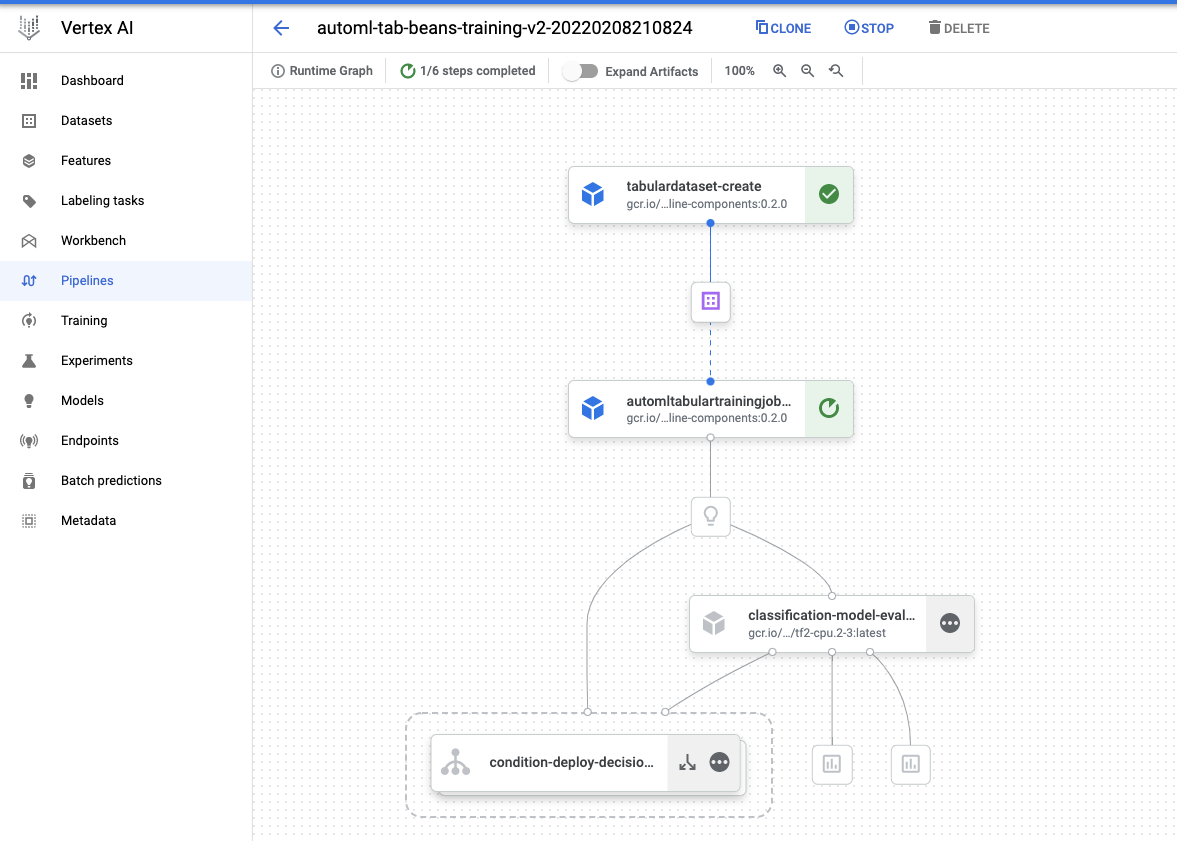


# 8.2) Visualing bis

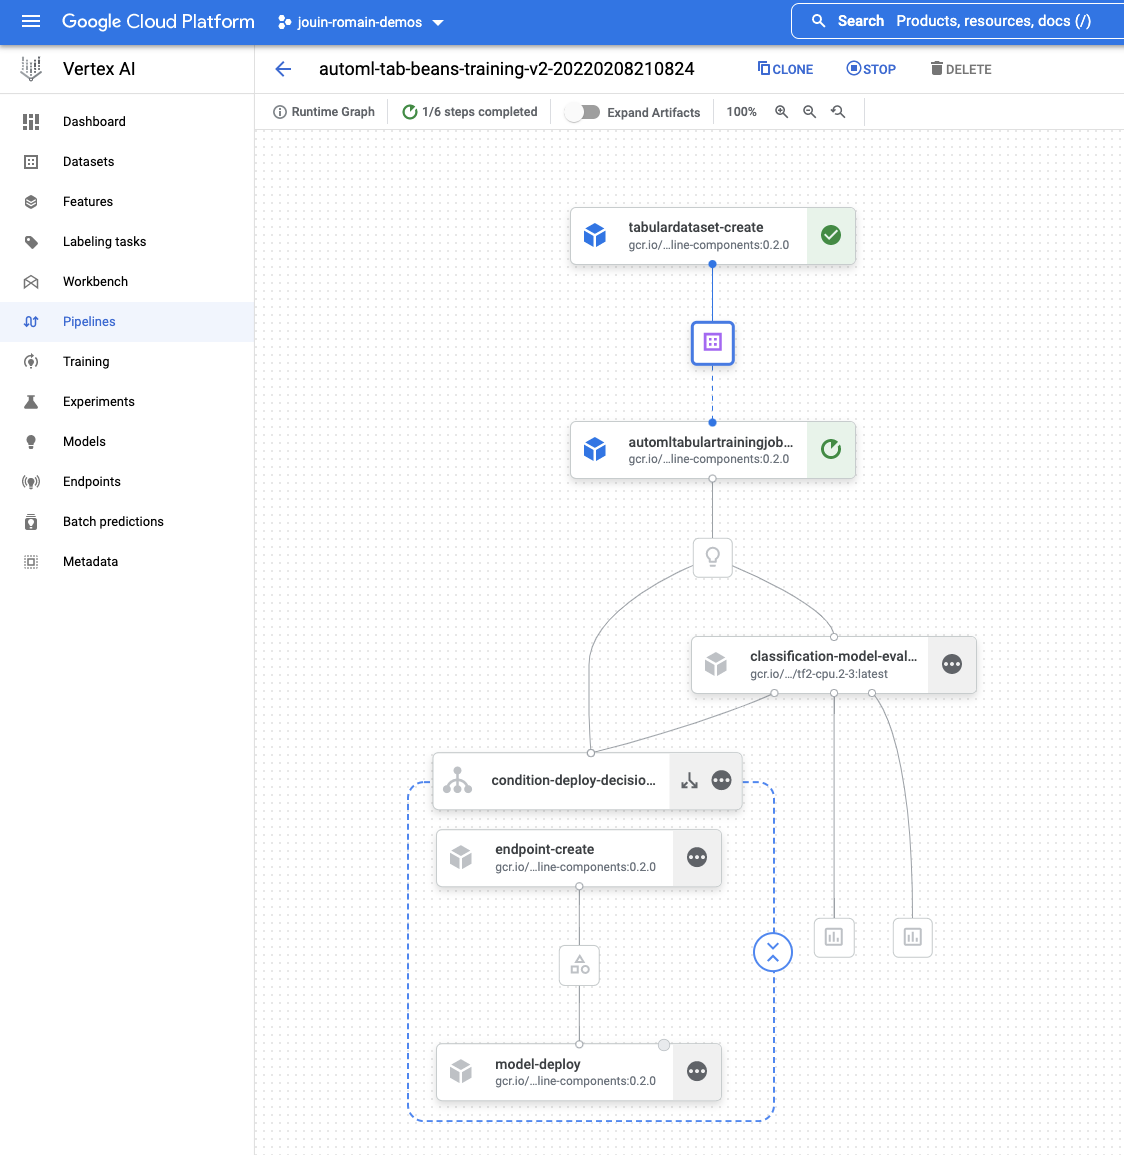

## 8.3) visualizing ter (and last)

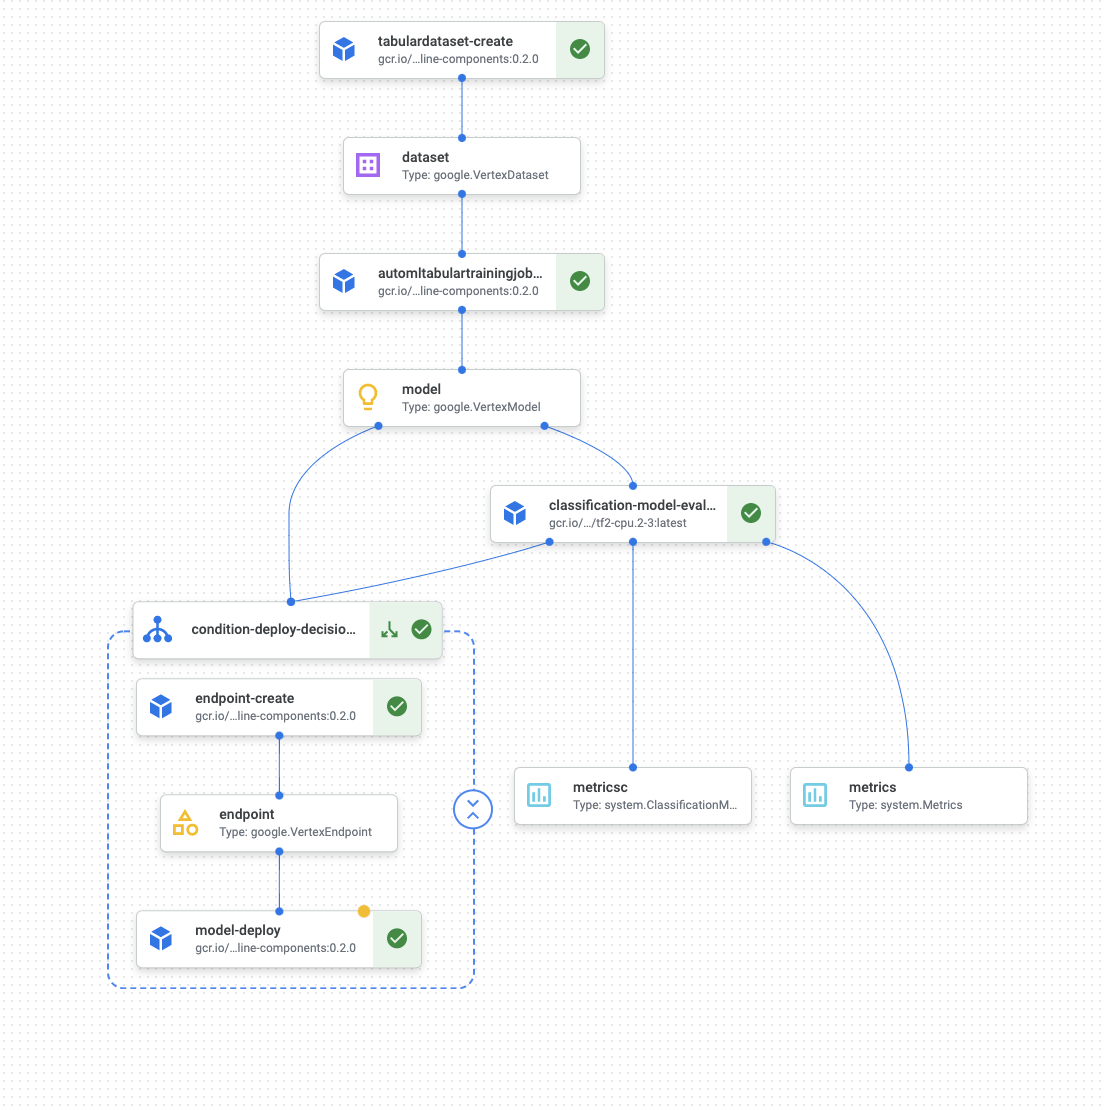

## 8.4) classification model evaluation dashboard output : 

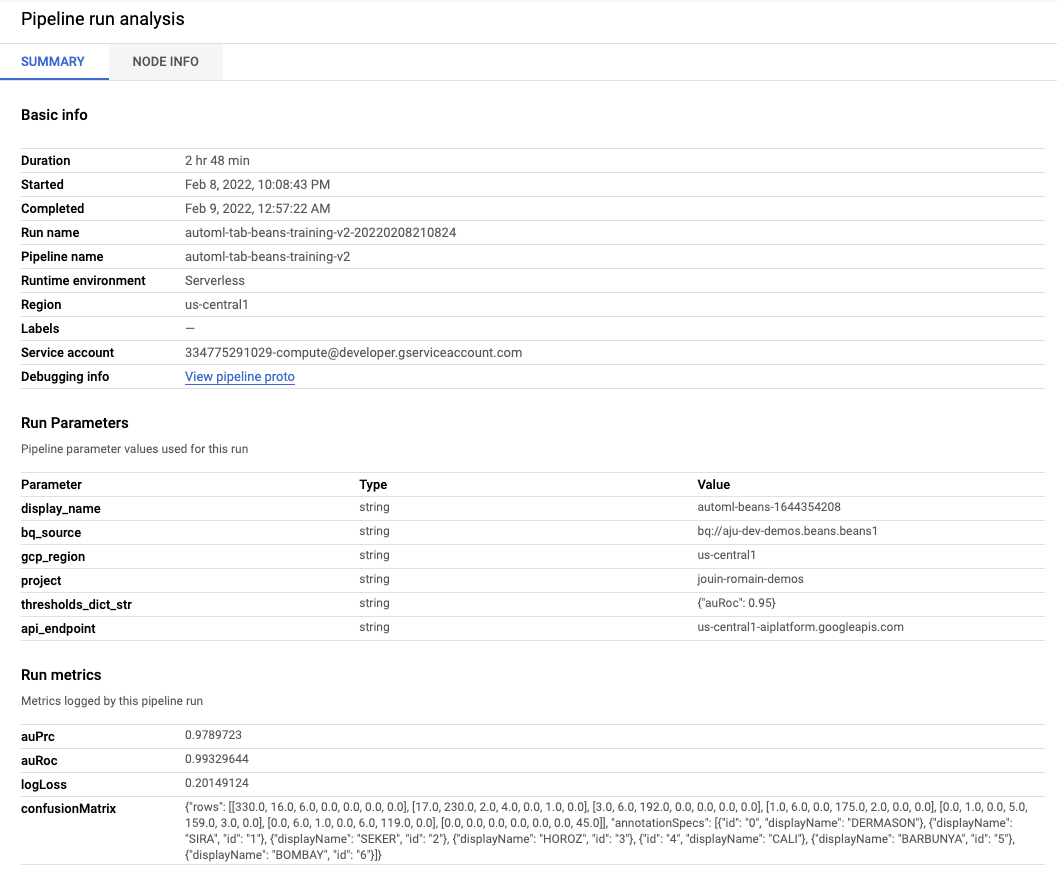

## 8.5) metrics on classification output 

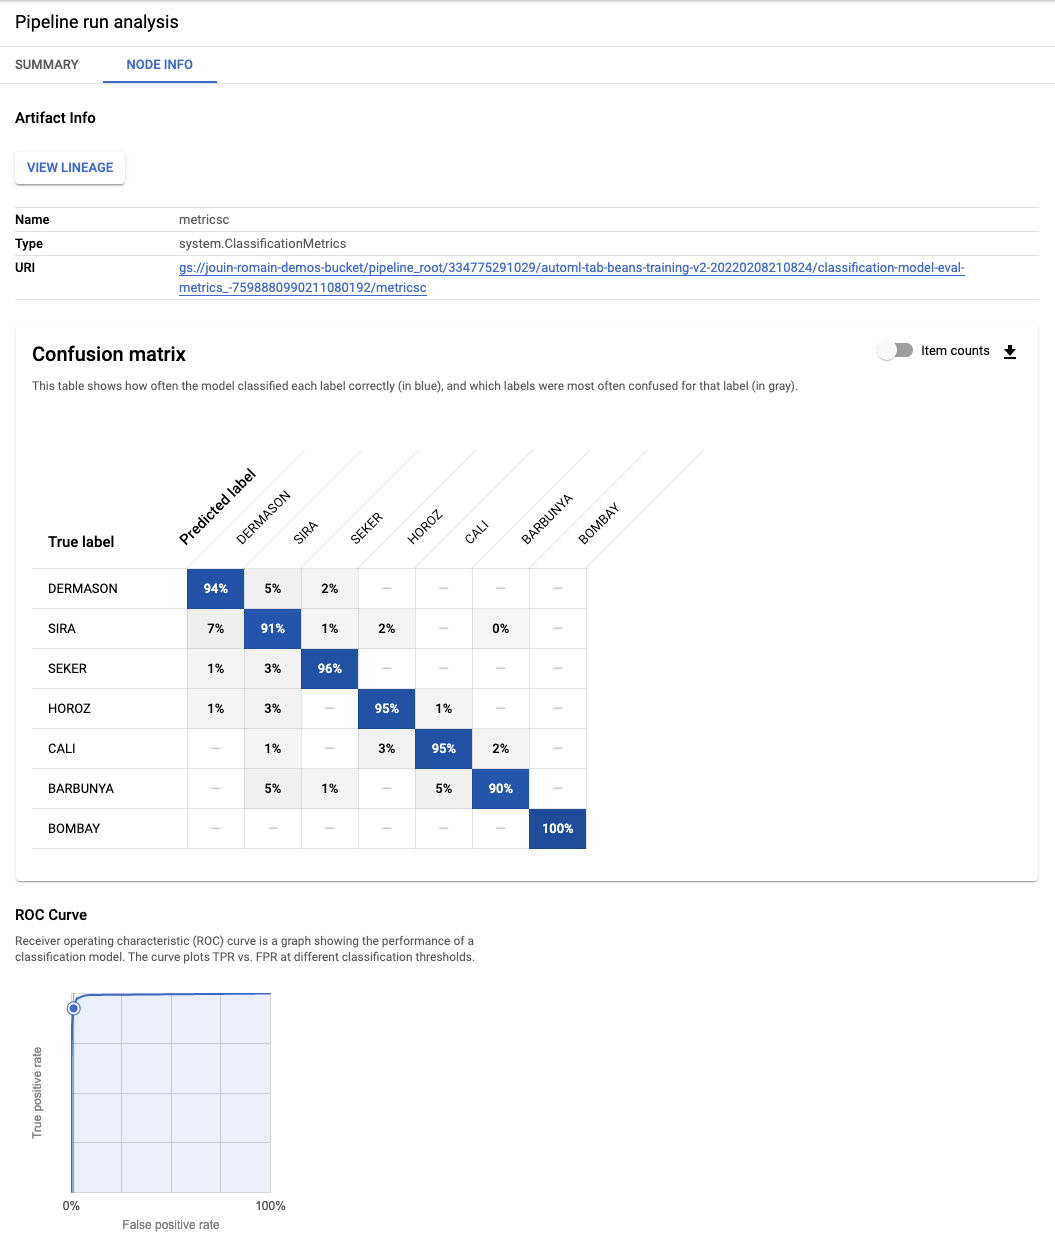

## 8.6) System metrics output

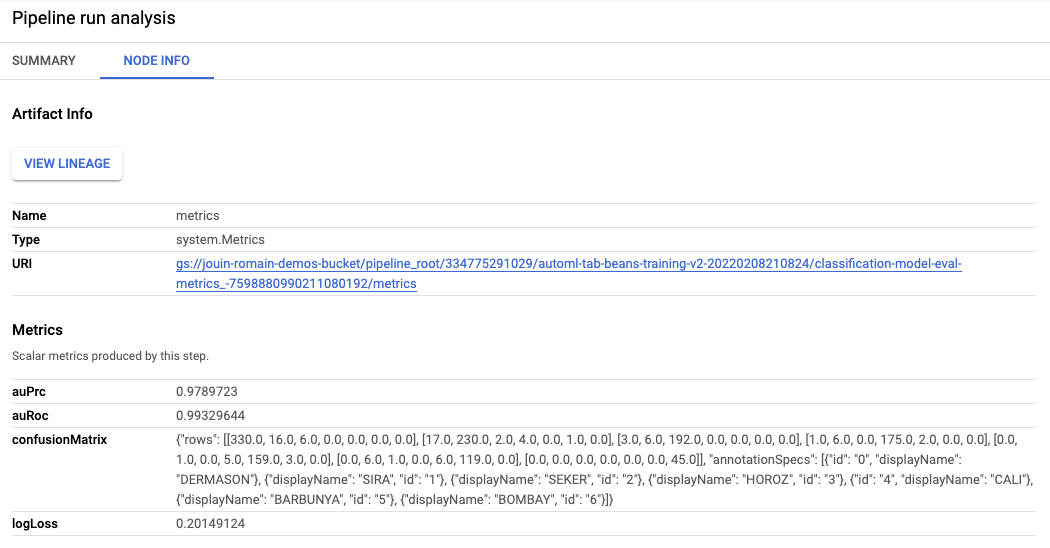

# 5) Using components stored in github

## 5.0) Store the yaml file in github

In [7]:
url_1 = "https://raw.githubusercontent.com/romainjouin/vertex-ai-demo/main/component-simple-string-return.yaml"
url_2 = "https://raw.githubusercontent.com/romainjouin/vertex-ai-demo/main/component-transform-string-to-emoji.yaml"
url_3 = "https://raw.githubusercontent.com/romainjouin/vertex-ai-demo/main/component-build-a-sentence.yaml"

## 5.1) Load them into the pipeline

In [14]:
parameters                  = {}
parameters["name"]          = "github-pipeline" 
parameters["description"]   = "An intro pipeline" 
parameters["pipeline_root"] = PIPELINE_ROOT # Bucket

@pipeline(**parameters)
# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex Pipelines", emoji_str: str = "sparkles"):
    
    product_name   = kfp.components.load_component_from_url(url_1)
    emoji          = kfp.components.load_component_from_url(url_2)
    build_sentence = kfp.components.load_component_from_url(url_3)
    task_product   = product_name(text)
    task_emoji     = emoji(emoji_str)
    
    parameters              = {}
    parameters["product"]   = task_product.output
    parameters["emoji"]     = task_emoji.outputs["emoji"]
    parameters["emojitext"] = task_emoji.outputs["emoji_text"]
    
    consumer_task = build_sentence(**parameters)

## 5.2) Compile the pipeline

In [15]:
pipeline_desc_in_json = "pipeline_from_github.json"

In [16]:
compiler_instance           = compiler.Compiler()
parameters                  = {}
parameters["pipeline_func"] = intro_pipeline
parameters["package_path"]  = pipeline_desc_in_json

compiler_instance.compile(**parameters)

## 5.3) Define a pipeline job

In [17]:
from datetime import datetime

TIMESTAMP                    = datetime.now().strftime("%Y%m%d%H%M%S")

parameters                   = {}
parameters["display_name"]   = "hello-world-pipeline"
parameters["template_path"]  = pipeline_desc_in_json
parameters["job_id"]         = f'{parameters["display_name"]}-{TIMESTAMP}'
parameters["enable_caching"] = True

In [15]:
parameters

{'display_name': 'hello-world-pipeline',
 'template_path': 'intro_pipeline_job.json',
 'job_id': 'hello-world-pipeline-20220620135906',
 'enable_caching': True}

In [18]:
job = aiplatform.PipelineJob(**parameters)

## 5.4) Submit the job

In [19]:
job.submit()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/334775291029/locations/us-central1/pipelineJobs/hello-world-pipeline-20220210122226
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/334775291029/locations/us-central1/pipelineJobs/hello-world-pipeline-20220210122226')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-pipeline-20220210122226?project=334775291029
